In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt

import sdss_gz_data as sgd

In [3]:
features = [
    'deVAB_i',
    'expAB_g',
    'expAB_i',
    'expAB_z',
    'expRad_g',
    'expRad_u',
    'expRad_z',
    'fiberMag_g',
    'fiberMag_u',
    'fiberMag_z',
    'model_g_u_colour_index',
    'model_i_r_colour_index',
    'model_r_g_colour_index',
    'model_z_i_colour_index',
    'dered_r',
    'petroRad_r',
    'petro_R90_R50_ratio_g',
    'petro_R90_R50_ratio_i',
    'petro_r_g_colour_index',
    'psfMag_r'    
]

In [4]:
orig_data = sgd.load_data('data/gz_nonspec_galaxies.csv.gz')

In [5]:
prepared_data = sgd.prepare_data(orig_data, init_galaxy_type=False, has_specz=False)

Filtered out 0 invalid records


In [6]:
len(orig_data)

10000

In [71]:
model_std = 0.012791338102239357
model_95_err = 2 * model_std

In [7]:
transform_data = sgd.transform_data(prepared_data)

In [8]:
combined_spiral = transform_data.spiralclock + transform_data.spiralanticlock + transform_data.edgeon
transform_data['combined_spiral'] = combined_spiral

In [9]:
at_least_80 = np.any([transform_data.combined_spiral >= 0.8, transform_data.elliptical >= 0.8], axis=0)
high_confidence_data = transform_data[at_least_80]

In [10]:
high_confidence_data['galaxy_type'] = 0
high_confidence_data.loc[high_confidence_data['elliptical'] >= 0.8,'galaxy_type'] = 1

/Users/will/Development/Astronomy/proposal/ENV/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/will/Development/Astronomy/proposal/ENV/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
len(high_confidence_data)

2502

In [12]:
X = high_confidence_data[features]

In [13]:
with open('x_scaler_new_split.pkl', 'rb') as f:
    import pickle
    
    x_scaler = pickle.load(f)

In [14]:
from sdss_gz_data import redshift_err
from keras.models import load_model
from keras.utils.generic_utils import get_custom_objects

get_custom_objects().update({"redshift_err": redshift_err})


Using TensorFlow backend.


In [15]:
with open('ann_2_layers_512_units_new_split_lower_lr.h5', 'rb') as f:
    ann_2_layers_512_units_new_split_lower_lr = pickle.load(f)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [16]:
#models = ann5_models
#models = ann_2_layers_512_units_new_split
models = ann_2_layers_512_units_new_split_lower_lr

In [17]:
def init_predictions(models, X):
    return np.zeros((len(models), len(X), 2))

def scale_x(X):
    return x_scaler.transform(X)

In [18]:
predictions = init_predictions(models, X) #np.zeros((len(models), len(y_))
X_test_scale = scale_x(X)
for idx, model in enumerate(models):
    prediction = np.array(model.predict(X_test_scale))
    # move indexes around
    prediction = np.transpose(prediction)[0]
    predictions[idx] = prediction

In [19]:
predictions_avg = np.mean(predictions, axis=0)
predictions_err = np.max(np.abs(predictions - predictions_avg), axis=0)
predictions_std = np.std(predictions, axis=0, ddof=1)

In [72]:
galaxy_classification_preds = predictions.transpose()[0]
galaxy_classifications = np.count_nonzero(np.round(galaxy_classification_preds, 0), axis=1)

y_results = high_confidence_data[['photoz','photozErr','galaxy_type']].reset_index()
y_results['z'] = y_results['photoz']
y_results['zErr'] = y_results['photozErr']

y_results['z_min_err'] = y_results['z'] - y_results['zErr']
y_results['z_plus_err'] = y_results['z'] + y_results['zErr']

y_results['galaxy_type_pred_raw'] = predictions_avg[:,0]
y_results['galaxy_type_pred_err'] = np.abs(y_results['galaxy_type_pred_raw'] - y_results['galaxy_type'])#predictions_err[:,0]
y_results['galaxy_type_pred_std'] = predictions_std[:,0]
y_results['galaxy_type_pred'] = np.round(y_results.galaxy_type_pred_raw,0)
y_results['galaxy_type_pred'] = y_results['galaxy_type_pred'].astype(int, copy=False)
y_results['elliptical_votes'] = galaxy_classifications
y_results['galaxy_type_pred_votes'] = 0
y_results.loc[y_results.elliptical_votes >= 3, 'galaxy_type_pred_votes'] = 1
y_results['correct_votes'] = galaxy_classifications
y_results.loc[y_results.galaxy_type == 0,'correct_votes'] = 5 - y_results['correct_votes']
y_results['incorrect_votes'] = 5 - y_results['correct_votes']
y_results['photoz'] = predictions_avg[:,1]
y_results['photoz_err'] = (y_results['z'] - y_results['photoz'])/(1 + y_results['z'])
y_results['photoz_err_abs'] = np.abs(y_results['photoz_err'])
y_results['photoz_std'] = predictions_std[:,1]

y_results['photoz_model_err'] = model_95_err
y_results['photoz_pred_err'] = 2 * predictions_std[:,1]

y_results['photoz_err_max'] = y_results[['photoz_model_err', 'photoz_pred_err']].max(axis=1)

y_results['photoz_min_err'] = y_results['photoz'] - y_results['photoz_err_max']
y_results['photoz_plus_err'] = y_results['photoz'] + y_results['photoz_err_max']


In [73]:
y_results[['z','z_min_err','z_plus_err', 'photoz', 'photoz_min_err', 'photoz_plus_err']]

,z,z_min_err,z_plus_err,photoz,photoz_min_err,photoz_plus_err
0,0.271910,0.257101,0.286719,0.270410,0.244827,0.295993
1,0.320285,0.301029,0.339541,0.318622,0.293040,0.344205
2,0.137303,0.115874,0.158732,0.130123,0.104540,0.155705
3,0.317152,0.294234,0.340070,0.312327,0.286744,0.337909
4,0.145057,0.135058,0.155056,0.150268,0.124685,0.175850
5,0.096594,0.067312,0.125876,0.072481,0.046898,0.098063
6,0.141282,0.129018,0.153546,0.145792,0.120209,0.171374
7,0.122269,0.109300,0.135238,0.123309,0.097726,0.148892
8,0.121325,0.097053,0.145597,0.124798,0.099215,0.150381
9,0.310639,0.294499,0.326779,0.311617,0.286034,0.337199


In [74]:
y_results[['galaxy_type', 'galaxy_type_pred', 'galaxy_type_pred_raw', 'galaxy_type_pred_err']]

,galaxy_type,galaxy_type_pred,galaxy_type_pred_raw,galaxy_type_pred_err
0,1,1,0.999833,0.000167
1,1,1,0.998738,0.001262
2,1,1,0.985594,0.014406
3,1,1,0.997217,0.002783
4,1,1,0.965888,0.034112
5,0,0,0.000173,0.000173
6,1,0,0.450147,0.549853
7,1,1,0.821997,0.178003
8,0,0,0.000592,0.000592
9,1,1,0.998427,0.001573


In [75]:
z_err_overlap_selector = np.all([
    y_results.photoz_min_err <= y_results.z_plus_err,
    y_results.photoz_plus_err >= y_results.z_min_err
], axis=0)

len(y_results[z_err_overlap_selector]), len(y_results[np.invert(z_err_overlap_selector)])

(2397, 105)

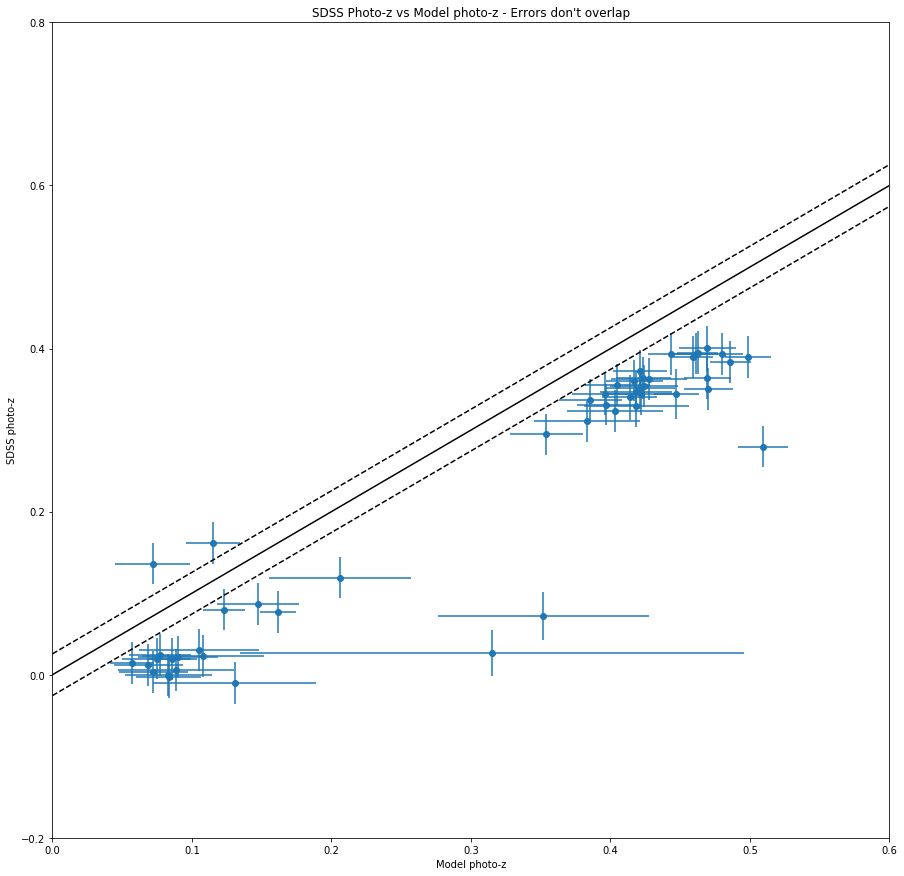

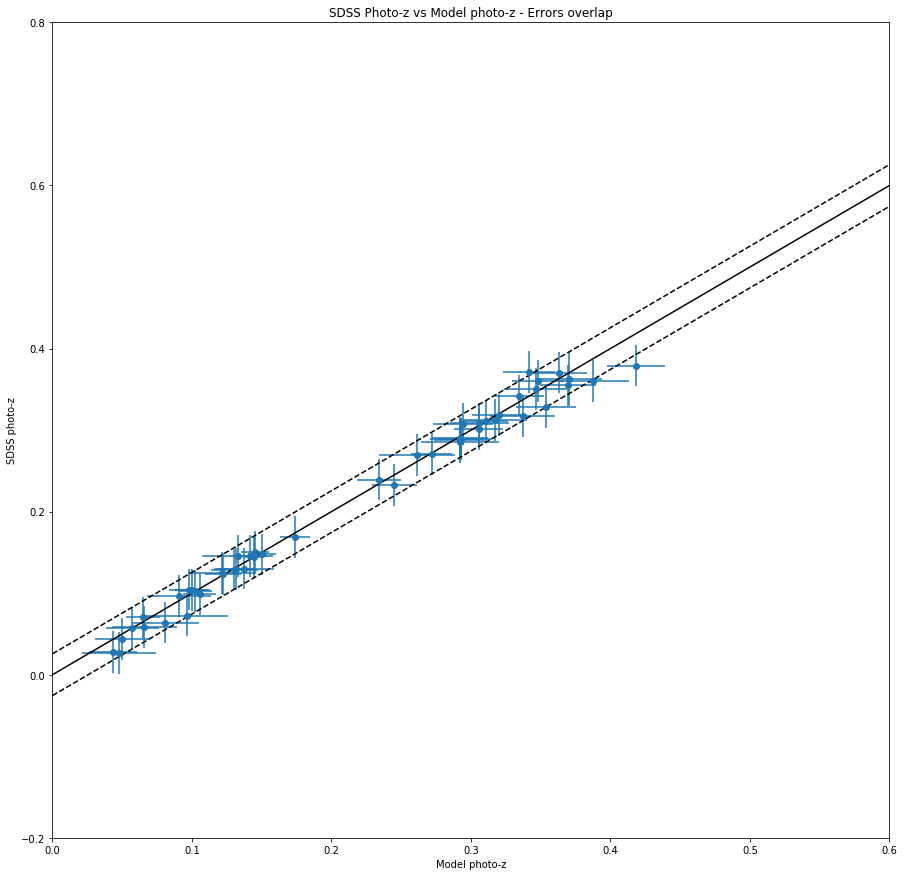

In [76]:
def plot_err(data, title, selector=None, number=20, min_z=0, max_z=0.6):
    fig, ax = plt.subplots(figsize=(15,15))

    lin = np.linspace(min_z, max_z, 100)

    if selector is not None:
        data = data[selector]

    range_selector = np.all([
        data.z_min_err >= min_z,
        data.z_plus_err <= max_z
    ], axis=0)
    data = data[range_selector]
    
    indexes = data.index.values
    np.random.shuffle(indexes)
    indexes = indexes[0:number]
    
    data = data.loc[indexes]

    ax.errorbar(
        data['z'],
        data['photoz'],
        xerr=data['zErr'],
        yerr=data['photoz_err_max'],
        fmt='o'
    )
    ax.plot(lin, lin + model_95_err, c='black', linestyle='--')
    ax.plot(lin, lin, c='black')
    ax.plot(lin, lin - model_95_err, c='black', linestyle='--')
    ax.set(title=title,
           ylabel='SDSS photo-z',
           xlabel='Model photo-z')
    ax.axis([min_z, max_z, min_z - 0.2, max_z + 0.2])
    plt.show()
    
plot_err(y_results, number=50, selector=np.invert(z_err_overlap_selector), title='SDSS Photo-z vs Model photo-z - Errors don\'t overlap')
plot_err(y_results, number=50, selector=z_err_overlap_selector, title='SDSS Photo-z vs Model photo-z - Errors overlap')

#plot_err(y_results, number=75)

# plot_err(y_results, number=75, min_z=0.4, max_z=0.7, selector=np.invert(z_err_overlap_selector))
# plot_err(y_results, number=75, min_z=0.4, max_z=0.7, selector=z_err_overlap_selector)


In [77]:
y_results['z_overlaps'] = 0
y_results.loc[z_err_overlap_selector, 'z_overlaps'] = 1

In [78]:
corr = y_results[['z', 'zErr', 'photoz', 'photoz_err', 'galaxy_type_pred_raw', 'z_overlaps']].corr()
# plt.figure(figsize=(15,15))
# plt.matshow(corr)
# plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
# plt.show()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,z,zErr,photoz,photoz_err,galaxy_type_pred_raw,z_overlaps
z,1,0.17,0.98,0.13,0.6,-0.23
zErr,0.17,1,0.069,0.49,-0.24,-0.21
photoz,0.98,0.069,1,-0.091,0.62,-0.1
photoz_err,0.13,0.49,-0.091,1,-0.049,-0.55
galaxy_type_pred_raw,0.6,-0.24,0.62,-0.049,1,-0.021
z_overlaps,-0.23,-0.21,-0.1,-0.55,-0.021,1


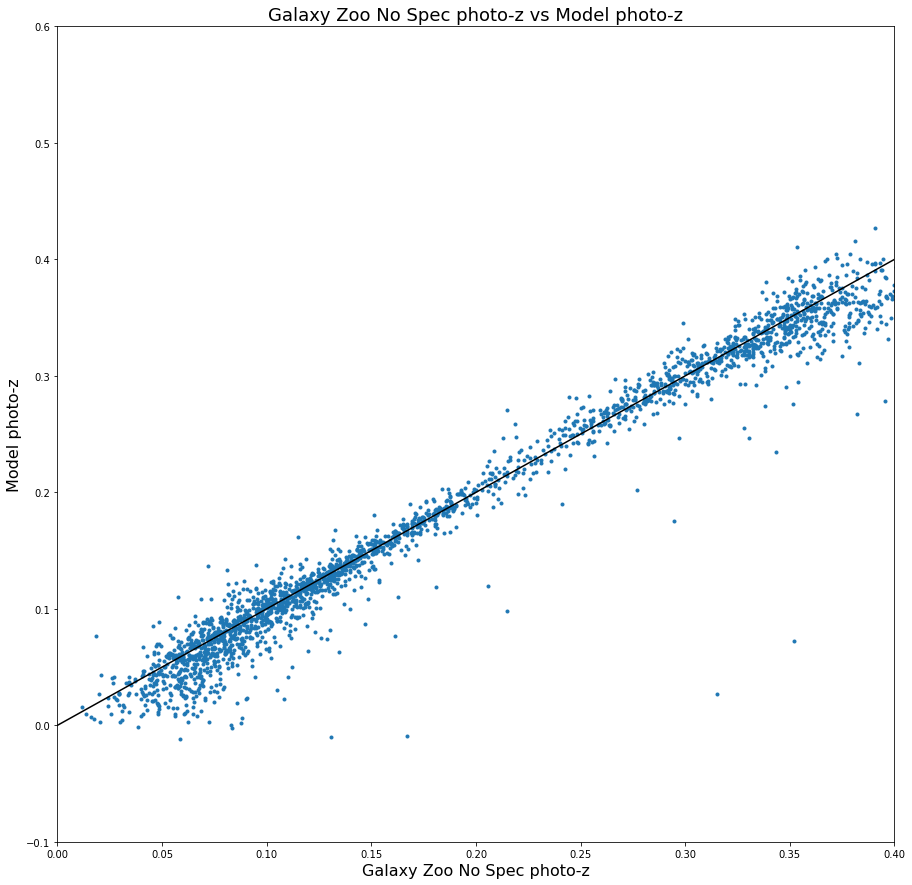

In [79]:
fig, ax = plt.subplots(figsize=(15,15))

lin = np.linspace(0, 0.6, 100)

ax.scatter(y_results['z'], y_results['photoz'], marker='.')
ax.plot(lin, lin, c='black')
ax.axis([0, 0.6, -0.2, 0.8])
ax.axis([0, 0.4, -0.1, 0.6])
ax.set_title('Galaxy Zoo No Spec photo-z vs Model photo-z', fontsize=18)
ax.set_xlabel('Galaxy Zoo No Spec photo-z', fontsize=16)
ax.set_ylabel('Model photo-z', fontsize=16)
plt.show()

In [80]:
overlap_results = y_results[z_err_overlap_selector]
np.max(overlap_results['zErr']), np.max(y_results['zErr'])

(0.093332, 0.180525)

In [81]:
len(overlap_results)

2397

In [82]:
len(y_results)

2502

In [44]:
len(overlap_results[overlap_results.z > 0.4])

25

In [45]:
np.max(y_results['z'])

0.563375

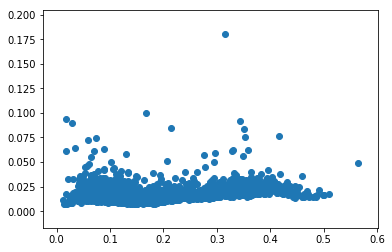

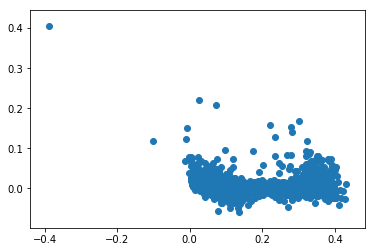

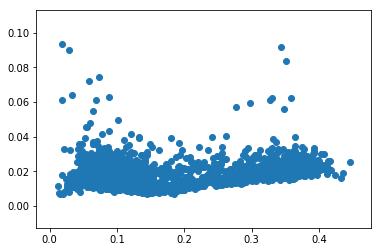

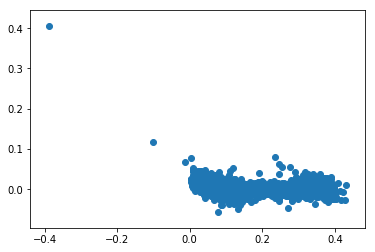

In [46]:
plt.scatter(y_results['z'], y_results['zErr'])
plt.show()

plt.scatter(y_results['photoz'], y_results['photoz_err'])
plt.show()

plt.scatter(overlap_results['z'], overlap_results['zErr'])
plt.show()

plt.scatter(overlap_results['photoz'], overlap_results['photoz_err'])
plt.show()

In [47]:
len(y_results[y_results.z >= 0.4])

85

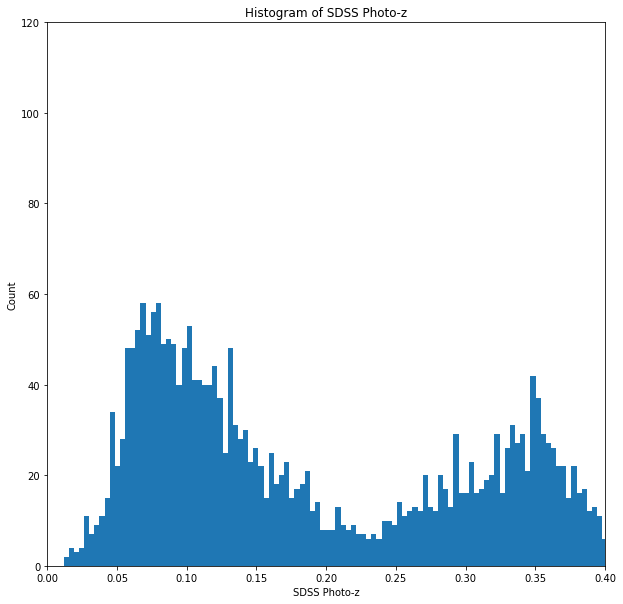

In [69]:
fig, ax = plt.subplots(figsize=(10,10))

ax.set(
    title='Histogram of SDSS Photo-z',
    xlabel='SDSS Photo-z',
    ylabel='Count'
)
ax.hist(y_results['z'], bins=150)
ax.axis([0, 0.4, 0, 120])
plt.show()

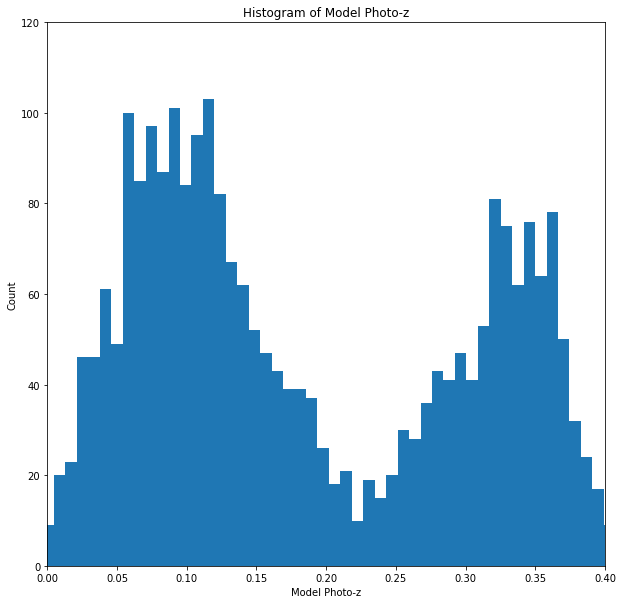

In [70]:
fig, ax = plt.subplots(figsize=(10,10))

ax.set(
    title='Histogram of Model Photo-z',
    xlabel='Model Photo-z',
    ylabel='Count'
)
ax.hist(y_results['photoz'], bins=100)
ax.axis([0, 0.4, 0, 120])
plt.show()

In [50]:
accum = 0
n_bins = 15
for i in range(n_bins + 1):
    min_range = 0.01 * i
    max_range = 0.01 * (i + 1)
    if (i == n_bins):
        max_range = 100.0

    selector = np.all([
        y_results.photoz_err_abs >= min_range,
        y_results.photoz_err_abs < max_range
    ], axis=0)
    num_of_records = len(y_results[selector])
    percentage = 100 * num_of_records / len(y_results)
    accum += percentage
    print(f'Z err between {min_range:0.2f} and {max_range:0.2f}: number = {num_of_records}, percentage = {percentage:0.2f}%, accum = {accum:0.2f}%')

Z err between 0.00 and 0.01: number = 1548, percentage = 61.87%, accum = 61.87%
Z err between 0.01 and 0.02: number = 534, percentage = 21.34%, accum = 83.21%
Z err between 0.02 and 0.03: number = 207, percentage = 8.27%, accum = 91.49%
Z err between 0.03 and 0.04: number = 86, percentage = 3.44%, accum = 94.92%
Z err between 0.04 and 0.05: number = 52, percentage = 2.08%, accum = 97.00%
Z err between 0.05 and 0.06: number = 24, percentage = 0.96%, accum = 97.96%
Z err between 0.06 and 0.07: number = 16, percentage = 0.64%, accum = 98.60%
Z err between 0.07 and 0.08: number = 12, percentage = 0.48%, accum = 99.08%
Z err between 0.08 and 0.09: number = 8, percentage = 0.32%, accum = 99.40%
Z err between 0.09 and 0.10: number = 3, percentage = 0.12%, accum = 99.52%
Z err between 0.10 and 0.11: number = 0, percentage = 0.00%, accum = 99.52%
Z err between 0.11 and 0.12: number = 2, percentage = 0.08%, accum = 99.60%
Z err between 0.12 and 0.13: number = 2, percentage = 0.08%, accum = 99.68

In [51]:
np.max(y_results.photoz_err_abs)

0.40588067548285395

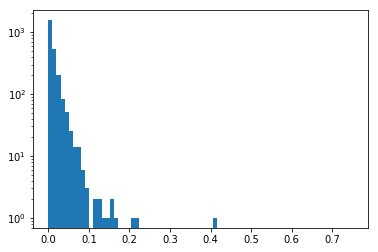

In [52]:
bins = np.linspace(0, 0.75, num=75)
_ = plt.hist(y_results.photoz_err_abs, bins=bins, log=True)

In [324]:
match_pred_galaxy_type = y_results.galaxy_type == y_results.galaxy_type_pred
correct_galaxy_type = y_results[match_pred_galaxy_type]
incorrect_galaxy_type = y_results[np.invert(match_pred_galaxy_type)]
len(correct_galaxy_type), len(incorrect_galaxy_type)

(2276, 226)

In [53]:
def overlaps(results, invert=False):
    selector = np.all([
        results.photoz_min_err <= results.z_plus_err,
        results.photoz_plus_err >= results.z_min_err
    ], axis=0)
    
    if invert:
        return results[np.invert(selector)]
    else:
        return results[selector]

def correct_galaxy_type(results, invert=False):
    selector = results.galaxy_type == results.galaxy_type_pred
    
    if invert:
        return results[np.invert(selector)]
    else:
        return results[selector]

#len(correct_galaxy_type(y_results)), len(correct_galaxy_type(y_results, invert=True)), len(overlaps(y_results)), len(overlaps(y_results, invert=True))
correct = correct_galaxy_type(overlaps(y_results))
correct_galaxy_incorrect_z = correct_galaxy_type(overlaps(y_results, invert=True))
incorrect_galaxy_correct_z = correct_galaxy_type(overlaps(y_results), invert=True)
incorrect = correct_galaxy_type(overlaps(y_results, invert=True), invert=True)

total_correct = len(correct)
total_incorrect = len(correct_galaxy_incorrect_z) + len(incorrect_galaxy_correct_z) + len(incorrect)
total_correct_galaxy = len(correct) + len(correct_galaxy_incorrect_z)
total_correct_z = len(correct) + len(incorrect_galaxy_correct_z)
total = len(y_results)

percent_correct = total_correct/total
percent_correct_galaxy = total_correct_galaxy/total
percent_correct_z = total_correct_z/total
percent_incorrect = total_incorrect/total

percent_correct, percent_correct_galaxy, percent_correct_z, percent_incorrect
# len(correct), len(incorrect), len(correct_galaxy_incorrect_z), len(incorrect_galaxy_correct_z)
# len(correct)/len(y_results), len(incorrect)/len(y_results), len(correct_galaxy_incorrect_z)/len(y_results), len(incorrect_galaxy_correct_z)/len(y_results)

# len(correct)/(len(correct) + len(correct_galaxy_incorrect_z))
# len(incorrect_galaxy_correct_z)/(len(incorrect) + len(incorrect_galaxy_correct_z) + len(correct_galaxy_incorrect_z))

(0.8685051958433253,
 0.9096722621902478,
 0.9564348521183054,
 0.13149480415667467)

In [54]:
top_100_correct = correct_galaxy_type.sort_values('galaxy_type_pred_err', ascending=True)[0:100]
top_100_correct_idxes = top_100_correct['index'].values

AttributeError: 'function' object has no attribute 'sort_values'

In [258]:
top_100_correct_data = high_confidence_data.loc[top_100_correct_idxes]

cols = ['objid', 'run', 'rerun', 'camcol', 'field', 'obj', 'elliptical', 'combined_spiral', 'galaxy_type']
# zns.nvote as votes, zns.p_el as elliptical,
# zns.p_cw as spiralclock, zns.p_acw as spiralanticlock, zns.p_edge as edgeon,
# zns.p_dk as dontknow, zns.p_mg as merger
top_100_correct_data[cols].sort_values(['combined_spiral', 'elliptical'], ascending=False)

,objid,run,rerun,camcol,field,obj,elliptical,combined_spiral,galaxy_type
2162,1237655126087172144,2247,301,5,222,48,0.000,1.000,0
552,1237655109449875523,2243,301,6,309,67,0.000,1.000,0
6966,1237662638526104113,3996,301,6,287,561,0.000,1.000,0
8959,1237668625166500014,5390,301,5,178,174,0.000,1.000,0
5986,1237654604246089783,2126,301,1,183,55,0.000,0.971,0
7616,1237662226219204686,3900,301,6,439,78,0.000,0.965,0
3825,1237655747235872865,2392,301,2,55,97,0.037,0.945,0
2173,1237651752942960838,1462,301,2,462,198,0.029,0.943,0
2624,1237668590262354083,5382,301,4,63,163,0.000,0.929,0
9441,1237655743485575306,2391,301,3,174,138,0.038,0.923,0


In [271]:
top_100_incorrect = incorrect_galaxy_type.sort_values('galaxy_type_pred_err', ascending=False)[0:100]
top_100_incorrect_idxes = top_100_incorrect['index'].values

,index,photoz,photozErr,galaxy_type,z,zErr,z_min_err,z_plus_err,galaxy_type_pred_raw,galaxy_type_pred_err,...,galaxy_type_pred,elliptical_votes,galaxy_type_pred_votes,correct_votes,incorrect_votes,photoz_err,photoz_err_abs,photoz_std,photoz_min_err,photoz_plus_err
1128,4569,0.110668,0.032227,1,0.084398,0.032227,0.052171,0.116625,0.001019,0.998981,...,0,0,0,0,5,-0.024225,0.024225,0.001473,0.109195,0.112141
208,859,0.121450,0.015844,1,0.081341,0.015844,0.065497,0.097185,0.001705,0.998295,...,0,0,0,0,5,-0.037092,0.037092,0.004315,0.117134,0.125765
1762,7204,0.013999,0.035596,1,0.048612,0.035596,0.013016,0.084208,0.002409,0.997591,...,0,0,0,0,5,0.033008,0.033008,0.003312,0.010687,0.017311
344,1385,0.068595,0.022317,1,0.083458,0.022317,0.061141,0.105775,0.004663,0.995337,...,0,0,0,0,5,0.013718,0.013718,0.002757,0.065838,0.071352
1593,6473,0.101769,0.012092,1,0.116076,0.012092,0.103984,0.128168,0.004902,0.995098,...,0,0,0,0,5,0.012819,0.012819,0.002326,0.099443,0.104095
701,2837,0.115249,0.021908,1,0.114867,0.021908,0.092959,0.136775,0.004905,0.995095,...,0,0,0,0,5,-0.000342,0.000342,0.002485,0.112764,0.117734
1769,7255,0.111623,0.014919,1,0.082141,0.014919,0.067222,0.097060,0.005524,0.994476,...,0,0,0,0,5,-0.027244,0.027244,0.002071,0.109552,0.113694
1861,7578,0.100752,0.029756,1,0.117509,0.029756,0.087753,0.147265,0.006267,0.993733,...,0,0,0,0,5,0.014995,0.014995,0.001170,0.099583,0.101922
684,2783,0.105935,0.024646,1,0.086491,0.024646,0.061845,0.111137,0.008944,0.991056,...,0,0,0,0,5,-0.017896,0.017896,0.003945,0.101990,0.109879
837,3393,0.123787,0.014088,1,0.103025,0.014088,0.088937,0.117113,0.009233,0.990767,...,0,0,0,0,5,-0.018823,0.018823,0.002447,0.121340,0.126234


In [265]:
top_100_incorrect_data = high_confidence_data.loc[top_100_incorrect_idxes]

cols = ['objid', 'run', 'rerun', 'camcol', 'field', 'obj', 'elliptical', 'combined_spiral', 'galaxy_type']
# zns.nvote as votes, zns.p_el as elliptical,
# zns.p_cw as spiralclock, zns.p_acw as spiralanticlock, zns.p_edge as edgeon,
# zns.p_dk as dontknow, zns.p_mg as merger
top_100_incorrect_data[cols].sort_values(['combined_spiral', 'elliptical'], ascending=False)

,objid,run,rerun,camcol,field,obj,elliptical,combined_spiral,galaxy_type
4267,1237660959184650430,3605,301,6,146,190,0.000,1.000,0
4162,1237658203429929010,2964,301,1,202,50,0.162,0.838,0
6041,1237662193984209022,3893,301,2,92,126,0.800,0.200,1
1121,1237661068185960682,3631,301,1,398,234,0.800,0.200,1
6473,1237662636378751478,3996,301,2,289,502,0.800,0.200,1
9948,1237662340553769429,3927,301,3,150,469,0.808,0.192,1
8375,1237664873502671391,4517,301,1,27,543,0.815,0.185,1
1007,1237665225700868287,4599,301,1,193,191,0.826,0.174,1
8015,1237658916924358704,3130,301,2,95,48,0.826,0.173,1
4790,1237660962937504047,3606,301,5,66,303,0.800,0.171,1


In [259]:
bttm_100_correct = correct_galaxy_type.sort_values('galaxy_type_pred_err', ascending=False)[0:100]
bttm_100_correct_idxes = bttm_100_correct['index'].values
bttm_100_correct

,index,photoz,photozErr,galaxy_type,z,zErr,z_min_err,z_plus_err,galaxy_type_pred_raw,galaxy_type_pred_err,...,galaxy_type_pred,elliptical_votes,galaxy_type_pred_votes,correct_votes,incorrect_votes,photoz_err,photoz_err_abs,photoz_std,photoz_min_err,photoz_plus_err
2286,9073,0.107208,0.014262,1,0.099678,0.014262,0.085416,0.113940,0.501781,0.498219,...,1,2,0,2,3,-0.006847,0.006847,0.002266,0.104942,0.109474
1856,7547,0.025686,0.016862,1,0.042222,0.016862,0.025360,0.059084,0.501888,0.498112,...,1,2,0,2,3,0.015866,0.015866,0.004512,0.021174,0.030198
1546,6258,0.118334,0.011258,1,0.119570,0.011258,0.108312,0.130828,0.503115,0.496885,...,1,2,0,2,3,0.001104,0.001104,0.001947,0.116387,0.120281
504,2082,0.109497,0.013393,1,0.110888,0.013393,0.097495,0.124281,0.505038,0.494962,...,1,3,1,3,2,0.001252,0.001252,0.001489,0.108008,0.110986
1387,5656,0.124620,0.024170,1,0.097075,0.024170,0.072905,0.121245,0.505114,0.494886,...,1,3,1,3,2,-0.025108,0.025108,0.002852,0.121768,0.127473
1961,7916,0.075827,0.018773,1,0.079087,0.018773,0.060314,0.097860,0.505976,0.494024,...,1,3,1,3,2,0.003021,0.003021,0.003962,0.071866,0.079789
855,3466,0.134352,0.013250,1,0.115802,0.013250,0.102552,0.129052,0.507904,0.492096,...,1,4,1,4,1,-0.016625,0.016625,0.006896,0.127456,0.141247
1422,5808,0.101379,0.011122,1,0.081036,0.011122,0.069914,0.092158,0.509114,0.490886,...,1,3,1,3,2,-0.018818,0.018818,0.002789,0.098590,0.104168
2357,9411,0.144448,0.008307,1,0.137710,0.008307,0.129403,0.146017,0.513318,0.486682,...,1,3,1,3,2,-0.005922,0.005922,0.002691,0.141756,0.147139
184,741,0.167686,0.039740,1,0.132751,0.039740,0.093011,0.172491,0.513510,0.486490,...,1,2,0,2,3,-0.030840,0.030840,0.021710,0.145976,0.189395


In [260]:
bttm_100_correct_data = high_confidence_data.loc[bttm_100_correct_idxes]

cols = ['objid', 'run', 'rerun', 'camcol', 'field', 'obj', 'elliptical', 'combined_spiral', 'galaxy_type']
bttm_100_correct_data[cols].sort_values(['combined_spiral', 'elliptical'], ascending=False)

,objid,run,rerun,camcol,field,obj,elliptical,combined_spiral,galaxy_type
6124,1237655747241312438,2392,301,2,138,182,0.018,0.982,0
236,1237665533332750494,4670,301,6,267,158,0.000,0.930,0
6126,1237665016314593454,4550,301,3,92,174,0.031,0.892,0
3275,1237650803729956955,1241,301,2,77,91,0.169,0.816,0
7547,1237655744551256105,2391,301,5,51,41,0.828,0.172,1
3405,1237650804267024601,1241,301,3,80,217,0.800,0.163,1
2375,1237650762929143929,1231,301,6,98,121,0.840,0.160,1
2051,1237663782592905490,4263,301,1,209,274,0.857,0.143,1
642,1237661068182094074,3631,301,1,339,250,0.818,0.136,1
4370,1237655495441187095,2333,301,5,21,279,0.815,0.130,1


In [293]:
bttm_100_incorrect = incorrect_galaxy_type.sort_values('galaxy_type_pred_err', ascending=True)[0:1000]
#bttm_100_incorrect_idxes = bttm_100_incorrect['index'].values
bttm_100_incorrect = bttm_100_incorrect.set_index('index', inplace=False).rename_axis(index=None)

In [296]:
bttm_100_incorrect_data = high_confidence_data.loc[bttm_100_incorrect.index]
bttm_100_incorrect_data['galaxy_type_pred_err'] = bttm_100_incorrect['galaxy_type_pred_err']
bttm_100_incorrect_data['galaxy_type_pred_raw'] = bttm_100_incorrect['galaxy_type_pred_raw']

cols = [
    'objid',
    'run',
    'rerun',
    'camcol',
    'field',
    'obj',
    'elliptical',
    'combined_spiral',
    'edgeon',
    'dontknow',
    'merger',
    'galaxy_type',
    'galaxy_type_pred_err',
    'galaxy_type_pred_raw'
]
bttm_100_incorrect_data[cols].sort_values(['galaxy_type_pred_err','galaxy_type_pred_raw'], ascending=True)

,objid,run,rerun,camcol,field,obj,elliptical,combined_spiral,edgeon,dontknow,merger,galaxy_type,galaxy_type_pred_err,galaxy_type_pred_raw
7099,1237658206123983103,2964,301,6,350,255,0.906,0.093,0.062,0.000,0.000,1,0.501681,0.498319
5411,1237650805883666511,1241,301,6,172,79,0.833,0.056,0.028,0.111,0.000,1,0.503074,0.496926
4597,1237658205575184552,2964,301,5,168,168,0.875,0.042,0.042,0.083,0.000,1,0.504630,0.495370
5141,1237651538714951839,1412,301,3,210,159,0.882,0.118,0.118,0.000,0.000,1,0.505162,0.494838
3117,1237650369399750807,1140,301,1,52,151,0.879,0.068,0.017,0.034,0.017,1,0.505508,0.494492
8065,1237657595144045133,2822,301,4,32,589,0.891,0.078,0.047,0.031,0.000,1,0.508925,0.491075
1289,1237665127464435781,4576,301,2,360,69,0.812,0.125,0.125,0.062,0.000,1,0.510453,0.489547
2814,1237648720670884284,756,301,2,78,444,0.931,0.034,0.034,0.034,0.000,1,0.515033,0.484967
2694,1237651250947162303,1345,301,3,134,191,0.821,0.142,0.071,0.036,0.000,1,0.516025,0.483975
8259,1237661971184877624,3841,301,3,124,56,0.917,0.028,0.014,0.042,0.014,1,0.517990,0.482010


In [55]:
sgd.classification_scores(y_results['galaxy_type'], y_results['galaxy_type_pred'])

[[ 485    2]
 [ 224 1791]]


{'recall': 0.888833746898263,
 'specificity': 0.9958932238193019,
 'precision': 0.9988845510317903,
 'accuracy': 0.9096722621902478,
 'f1': 0.9406512605042017,
 'mcc': 0.7773167215917479}

In [56]:
len(y_results[y_results.galaxy_type == 0]), len(y_results[y_results.galaxy_type == 1])

(487, 2015)

In [57]:
sgd.classification_scores(y_results['galaxy_type'], y_results['galaxy_type_pred_votes'])

[[ 485    2]
 [ 222 1793]]


{'recall': 0.8898263027295286,
 'specificity': 0.9958932238193019,
 'precision': 0.9988857938718663,
 'accuracy': 0.9104716227018386,
 'f1': 0.9412073490813648,
 'mcc': 0.7788544251121037}

In [58]:
len(y_results[y_results.galaxy_type_pred_err <= 0.5])/len(y_results)

0.9096722621902478

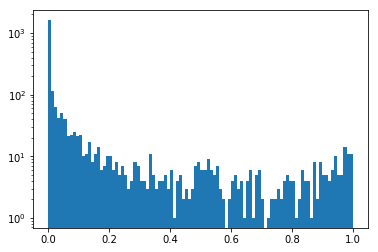

In [60]:
plt.hist(y_results['galaxy_type_pred_err'], bins=100, log=True)
plt.show()

In [61]:
from scipy import stats

In [62]:
res = stats.cumfreq(y_results['galaxy_type_pred_err'], numbins=100)

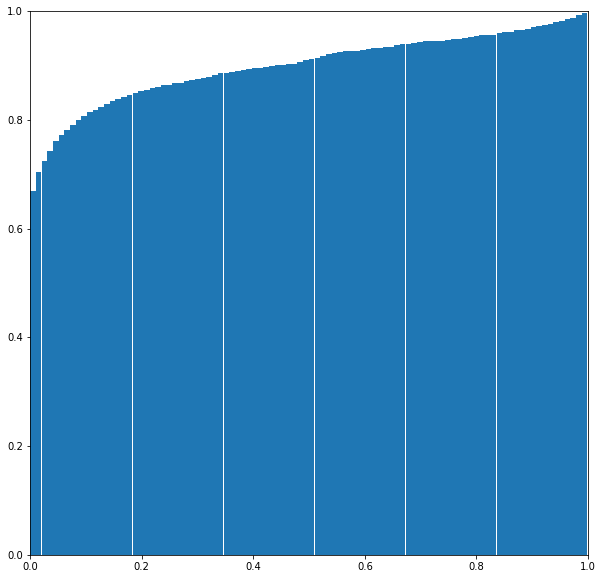

In [63]:
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size,
                    res.cumcount.size)
plt.figure(figsize=(10,10))
plt.bar(x, res.cumcount/len(y_results), width=res.binsize)
plt.axis([0,1,0,1])
plt.show()